[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iNANOV/quant-models-lab/blob/main/experiments/gaussian_hmm/gaussian_hmm_regime_forecast.ipynb)

# 🔬 Regime Detection Using Gaussian HMMs

**Author:** Iliya Nanov  
**Date:** 2025-08-16  
**Tags:** `HMM` · `Viterbi` · `Forward-Backward` · `Regime Detection` · `Quantitative Finance` · `Colab`  
**GitHub:** [github.com/iNANOV/quant-models-lab](https://github.com/iNANOV/quant-models-lab/tree/main/experiments/gaussian_hmm)

---

This notebook explores the use of a **Gaussian Hidden Markov Model (HMM)** to detect latent  
**market regimes** in S&P 500 returns. It compares **Forward–Backward probabilities** with  
**Viterbi decoding** for regime path inference and demonstrates how regime signals can  
enhance short-term return forecasting.

# 📘 Abstract

This study applies a **Gaussian Hidden Markov Model (HMM)** to weekly S&P 500 returns in order to capture latent **market regimes**: **neutral**, **bear**, and **bull**. The data is **detrended** using a weighted moving average and adjusted for volatility to enhance stationarity.

Two inference approaches are compared:  
- **Forward–Backward (FB)** decoding, which yields **probabilistic regime forecasts** and next-step observation expectations.  
- **Viterbi decoding**, which provides a **single most likely regime path**, producing smoother state sequences.

Forecasts of regime probabilities are projected one step ahead using the FB algorithm, while Viterbi states are overlayed as **dashed regime indicators**. Visualization integrates both methods into a **candlestick chart with probability panels**, highlighting alignment and divergence between probabilistic forecasts and hard-decoded regime paths.

> 🧠 This framework balances **probabilistic forecasting** (FB) with **interpretable path decoding** (Viterbi), offering a dual perspective on regime dynamics in financial markets.


# 🔧 Data & Functions & Packages

In [ ]:
pip install mplfinance

In [2]:
# Force overwrite by renaming explicitly
!wget -O functions.py https://raw.githubusercontent.com/iNANOV/quant-models-lab/main/experiments/gaussian_hmm/functions.py

import importlib.util

spec = importlib.util.spec_from_file_location("functions", "./functions.py")
functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(functions)

# Verify all functions
print([f for f in dir(functions) if not f.startswith("_")])


--2025-08-16 14:24:19--  https://raw.githubusercontent.com/iNANOV/quant-models-lab/main/experiments/gaussian_hmm/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11135 (11K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]  10.87K  --.-KB/s    in 0s      

2025-08-16 14:24:20 (84.9 MB/s) - ‘functions.py’ saved [11135/11135]

['GaussianHMM', 'evaluate_bear_signals', 'forecast_all_next_states_and_observations', 'generate_bear_performance_table', 'norm', 'np', 'pd', 'plt', 'step7_check_convergence', 'step8_infer_hidden_states']


In [3]:
import yfinance as yf
import pandas as pd

# Download data
ticker = yf.Ticker("^GSPC")
data = ticker.history(start="2000-01-01")

# Check if data is empty
print("Raw data shape:", data.shape)

# Remove timezone if present
data.index = data.index.tz_localize(None)

# Resample to weekly (Friday close)
df = data.resample('W-FRI').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

# Final formatting
df.reset_index(inplace=True)
df.columns = df.columns.str.lower()

df

Raw data shape: (6444, 7)


,date,open,high,low,close,volume
0,2000-01-07,1469.250000,1478.000000,1377.680054,1441.469971,5343800000
1,2000-01-14,1441.469971,1473.000000,1427.079956,1465.150024,5169700000
2,2000-01-21,1465.150024,1465.709961,1438.540039,1441.359985,4455000000
3,2000-01-28,1441.359985,1454.089966,1356.199951,1360.160034,5532100000
4,2000-02-04,1360.160034,1435.910034,1350.140015,1424.369995,5205000000
...,...,...,...,...,...,...
1332,2025-07-18,6255.149902,6315.609863,6201.589844,6296.790039,25730370000
1333,2025-07-25,6304.740234,6395.819824,6281.709961,6388.640137,26068830000
1334,2025-08-01,6397.689941,6427.020020,6212.689941,6238.009766,26921040000
1335,2025-08-08,6271.709961,6395.160156,6271.709961,6389.450195,25844550000


# 🧠 Model

## Weighted Moving Average and Detrended Return Formulas

---

### 📐 **Weighted Moving Average (WMA)**

The **Weighted Moving Average** of `open` prices over a window size *n* with weights *wₖ = k* is defined as:

$$
\mathrm{WMA}_t = \frac{\sum_{k=1}^{n} w_k \cdot \mathrm{open}_{t-n+k}}{\sum_{k=1}^{n} w_k}
$$

Where:  
- *openₜ*: Open price at time *t*  
- *wₖ = k*: Weights increasing linearly from 1 to *n*

---

### 📉 **Detrended Open**

The **detrended open** is calculated as:

$$
\mathrm{detrended\_open}_t = \frac{\mathrm{open}_t}{\mathrm{WMA}_{t-1}} - 1
$$

Where *WMAₜ₋₁* is the lagged WMA.

---

### 📏 **Range Factor**

The **range factor** measures the high-low range relative to the low price:

$$
\mathrm{range\_factor}_t = 1 + \frac{\mathrm{high}_t - \mathrm{low}_t}{\mathrm{low}_t + \epsilon}
$$

Where:  
- *epsilon*: A small constant (e.g., 1e-6) to avoid division by zero.

---

### 📈 **Weighted Detrended Return**

The final **weighted detrended return** is computed as:

$$
\mathrm{return}_t = \mathrm{detrended\_open}_t \cdot \mathrm{range\_factor}_t
$$

---

### 📝 **Original Full Formula (Alternative)**

Alternatively, the original formula you commented in code can be written as:

$$
\mathrm{return}_t =
\left( \frac{\mathrm{high}_t - \mathrm{low}_t}{\mathrm{low}_t} + 1 \right)
\cdot \mathrm{WMA}_{t-1}
\cdot
\frac{
\mathrm{WMA}_{t-1} \cdot \mathrm{open}_t - \mathrm{WMA}_t \cdot \mathrm{open}_{t-1}
}{
\mathrm{open}_{t-1} - \mathrm{WMA}_{t-1}
}
$$

Where:  
- *highₜ*, *lowₜ*, *openₜ*: High, low, and open prices at time *t*  
- *WMAₜ*: Weighted moving average at time *t*

---


In [4]:
import pandas as pd
import numpy as np

# WMA parameters
n = 26  # window length
weights = np.arange(1, n + 1)

def weighted_moving_average(series, n):
    def wma(x):
        return (x * weights).sum() / weights.sum()
    return series.rolling(n).apply(wma, raw=True)

# Compute WMA for open prices
df['wma_open'] = weighted_moving_average(df['open'], n)

# Compute detrended return
df['detrended_open'] = (df['open'] / df['wma_open'].shift(1)) - 1

# Compute range factor
df['range_factor'] = 1 + (df['high'] - df['low']) / (df['low'] + 1e-6)

# Weighted detrended return
df['return'] = df['detrended_open'] * df['range_factor']

# Split train/test
start_date = '2023-12-31'
df_train = df[df['date'] < start_date].copy()
df_test = df[df['date'] >= start_date].copy()

# Clean NA from WMA in train
df_train = df_train.dropna(subset=['return'])

## Baum–Welch Algorithm for Gaussian HMM

### Setup and Notation

We work with a Hidden Markov Model (HMM) with:

- $N$ hidden states labeled $1, 2, \dots, N$  
- An observation sequence of length $T$:

$$
O = (O_1, O_2, \dots, O_T)
$$

- Initial state probabilities $\pi_i$: probability that the system starts in state $i$  
- Transition probabilities $A_{ij}$: probability of transitioning from state $i$ to $j$  
- Emission distributions modeled as Gaussian with parameters $\mu_i$ and $\sigma_i$ for state $i$:

$$
B_i(O_t) = p(O_t \mid q_t = i) = \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left(-\frac{(O_t - \mu_i)^2}{2 \sigma_i^2}\right)
$$

**Goal**: Estimate the parameters $\pi$, $A$, $\mu$, and $\sigma$ that maximize the likelihood of the observed sequence $O$.

---

### Step 1: Forward Probabilities

Define the forward variable $\alpha_t(i)$ as the probability of the partial observation sequence $(O_1, \dots, O_t)$ and being in state $i$ at time $t$.

**Initialization ($t = 1$):**

$$
\alpha_1(i) = \pi_i \cdot B_i(O_1)
$$

**Recursion ($t = 2, \dots, T$):**

$$
\alpha_t(j) = \left( \sum_{i=1}^N \alpha_{t-1}(i) \cdot A_{ij} \right) \cdot B_j(O_t)
$$

---

### Step 2: Backward Probabilities

Define the backward variable $\beta_t(i)$ as the probability of the partial observation sequence from $O_{t+1}$ to $O_T$ given the current state is $i$ at time $t$.

**Initialization ($t = T$):**

$$
\beta_T(i) = 1
$$

**Recursion ($t = T-1, \dots, 1$):**

$$
\beta_t(i) = \sum_{j=1}^N A_{ij} \cdot B_j(O_{t+1}) \cdot \beta_{t+1}(j)
$$

---

### Step 3: Total Probability of the Observed Sequence

Using either the forward or backward variables:

$$
P(O) = \sum_{i=1}^N \alpha_T(i) = \sum_{i=1}^N \pi_i \cdot B_i(O_1) \cdot \beta_1(i)
$$

---

### Step 4: Gamma $\gamma_t(i)$

Probability of being in state $i$ at time $t$, given the entire observation sequence:

$$
\gamma_t(i) = \frac{\alpha_t(i) \cdot \beta_t(i)}{P(O)}
$$

> This is a direct application of Bayes’ Theorem.

---

### Step 5: Xi $\xi_t(i, j)$

Probability of being in state $i$ at time $t$, and in state $j$ at time $t+1$:

$$
\xi_t(i, j) = \frac{\alpha_t(i) \cdot A_{ij} \cdot B_j(O_{t+1}) \cdot \beta_{t+1}(j)}{P(O)}
$$

---

### Step 6: Re-estimate Model Parameters

**Initial State Probabilities:**

$$
\pi_i^{\text{new}} = \gamma_1(i)
$$

**Transition Probabilities:**

$$
A_{ij}^{\text{new}} = \frac{\sum_{t=1}^{T-1} \xi_t(i, j)}{\sum_{t=1}^{T-1} \gamma_t(i)}
$$

**Gaussian Emission Parameters:**

Update mean and variance for each state $i$ as weighted averages using $\gamma_t(i)$:

$$
\mu_i^{\text{new}} = \frac{\sum_{t=1}^T \gamma_t(i) \cdot O_t}{\sum_{t=1}^T \gamma_t(i)}
$$

$$
(\sigma_i^2)^{\text{new}} = \frac{\sum_{t=1}^T \gamma_t(i) \cdot (O_t - \mu_i^{\text{new}})^2}{\sum_{t=1}^T \gamma_t(i)}
$$

---

### Step 7: Iterate Until Convergence

Repeat Steps 1–6 using updated parameters until the log-likelihood $P(O)$ converges or changes less than a threshold.

---

### Step 8: Decoding Hidden States

#### 1. Forward–Backward (Posterior Decoding)

For each time $t$, assign:

$$
\hat{s}_t = \arg\max_i \gamma_t(i)
$$

> Gives the most likely state at each time independently.

---

#### 2. Viterbi Algorithm (Most Likely Path Decoding)

Find the single most likely full path $S = (s_1, \dots, s_T)$ that maximizes:

$$
P(S \mid O, \lambda)
$$

> This gives the most probable *overall* path — not per-step marginals.

---

#### When to Use Which?

| Goal                              | Use               |
|----------------------------------|-------------------|
| Most probable state at each time  | Forward–Backward  |
| Most probable overall sequence    | Viterbi           |

---

### Step 9: Forecasting the Next Hidden State

Use posterior $\gamma_T(i)$ and the transition matrix $A$:

$$
P(q_{T+1} = j \mid O_{1:T}) = \sum_{i=1}^N \gamma_T(i) \cdot A_{ij}
$$

> This gives a probability distribution over the possible next hidden states.

---

### Step 10: Forecasting the Next Observation

Use the predicted hidden state distribution and the Gaussian emission parameters:

$$
E[O_{T+1} \mid O_{1:T}] = \sum_{j=1}^N P(q_{T+1} = j \mid O_{1:T}) \cdot \mu_j
$$

> This gives the expected next observation as a weighted average of state means.

---

### ✅ Summary

| Step | Purpose                    | Method                       |
|-------|---------------------------|------------------------------|
| 1–6   | Parameter estimation       | Baum–Welch (EM)              |
| 7     | Convergence check          | Log-likelihood monitoring    |
| 8     | Hidden state inference     | Forward–Backward or Viterbi  |
| 9     | Forecast next hidden state | Posterior + Transition matrix|
| 10    | Forecast next observation  | Weighted Gaussian means      |


# 🏋️ Train Model

In [5]:
# Drop missing return values
df_train = df_train.dropna(subset=['return'])

# Initialize and train model
model = functions.GaussianHMM(n_states=3, n_iter=50)
model.fit(df_train['return'].values)

# Assign most likely hidden state (regime) to each time point
df_train['regime'] = model.predict(df_train['return'].values)
df_train

,date,open,high,low,close,volume,wma_open,detrended_open,range_factor,return,regime
26,2000-07-07,1454.599976,1484.119995,1439.560059,1478.900024,3350200000,1436.813351,0.013621,1.030954,0.014043,0
27,2000-07-14,1478.900024,1509.989990,1470.479980,1509.979980,4807800000,1440.415575,0.029292,1.026869,0.030079,0
28,2000-07-21,1509.979980,1517.319946,1477.910034,1480.189941,4756600000,1446.213381,0.048295,1.026666,0.049583,0
29,2000-07-28,1480.189941,1485.880005,1413.890015,1419.890015,5221900000,1449.676796,0.023493,1.050916,0.024690,0
30,2000-08-04,1419.890015,1462.930054,1418.709961,1462.930054,4937400000,1448.562923,-0.020547,1.031169,-0.021188,0
...,...,...,...,...,...,...,...,...,...,...,...
1247,2023-12-01,4554.859863,4599.390137,4537.240234,4594.629883,21205410000,4394.230175,0.039476,1.013698,0.040017,0
1248,2023-12-08,4564.370117,4609.229980,4546.500000,4604.370117,20051430000,4406.348647,0.038719,1.013797,0.039253,0
1249,2023-12-15,4593.390137,4738.569824,4593.390137,4719.189941,27228260000,4419.815097,0.042448,1.031606,0.043790,0
1250,2023-12-22,4725.580078,4778.009766,4697.819824,4754.629883,18766580000,4442.261229,0.069180,1.017070,0.070361,2


In [6]:
# Regimes
regime_names = ['neutral', 'bear', 'bull']
for i, (mu, sigma) in enumerate(zip(model.mu, model.sigma)):
    print(f"Regime {i}: mean = {mu:.5f}, std = {sigma:.5f}, {regime_names[i]}")


Regime 0: mean = 0.01665, std = 0.01814, neutral
Regime 1: mean = -0.06528, std = 0.05878, bear
Regime 2: mean = 0.05685, std = 0.02022, bull


Log-likelihood difference between last two iterations: 0.00419486
Not converged yet.


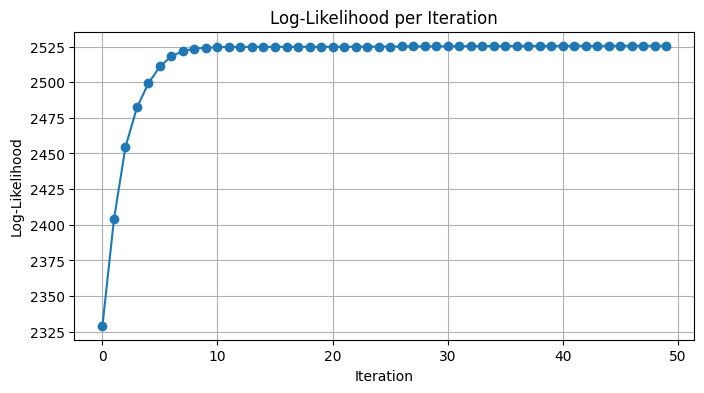

np.False_

In [7]:
# Plot / convergence check
functions.step7_check_convergence(model.log_likelihoods_, tol=1e-6, plot=True)

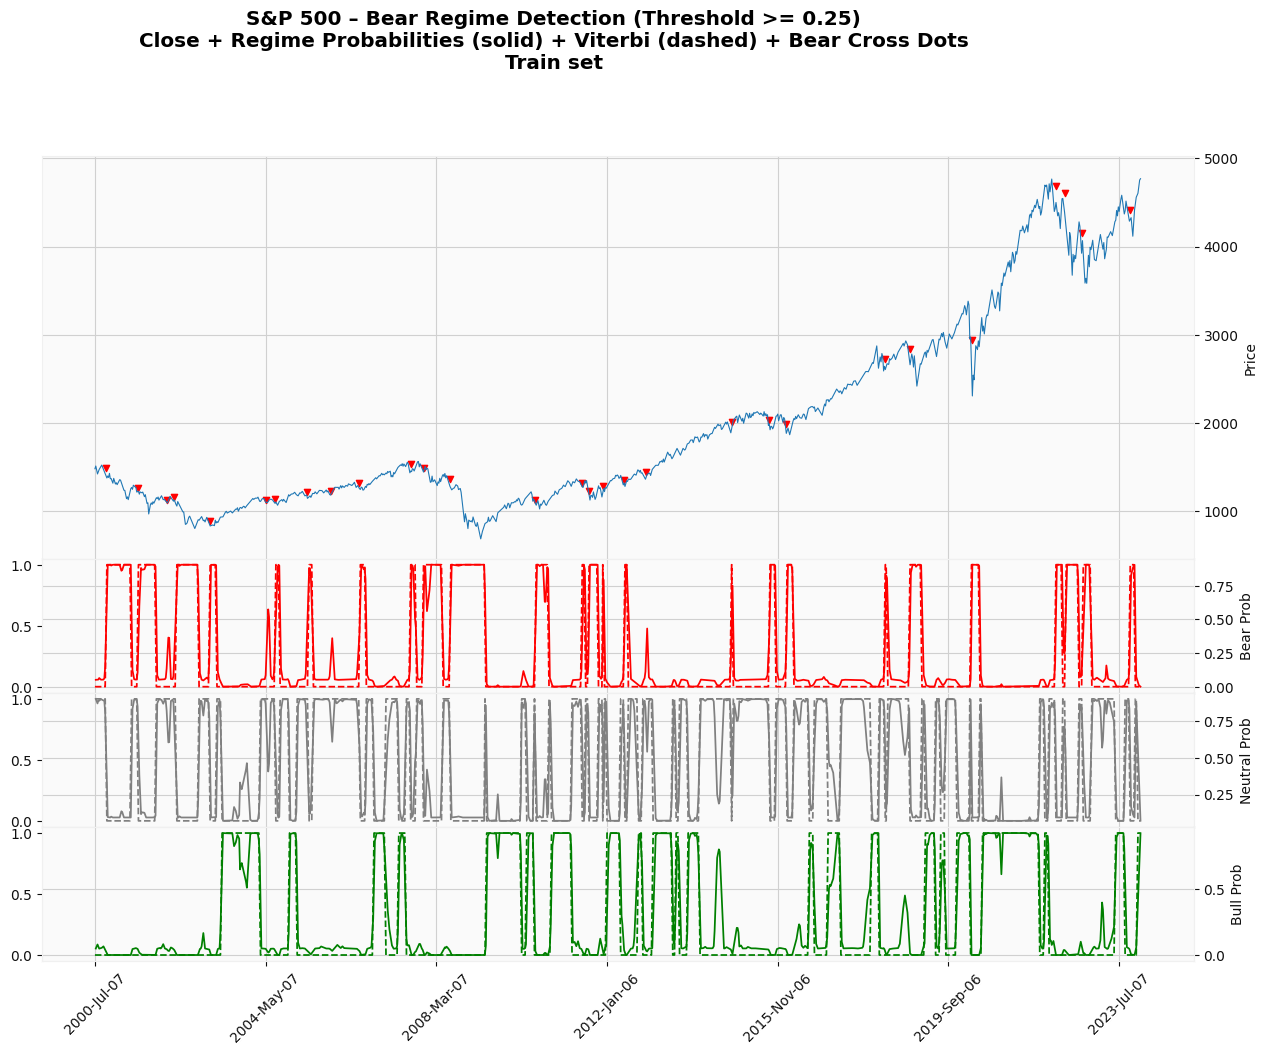

In [8]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import functions  # your custom functions

# --- Ensure datetime index ---
if not isinstance(df_train.index, pd.DatetimeIndex):
    df_train = df_train.set_index(pd.to_datetime(df_train['date']))

# --- Viterbi decoding on train data ---
viterbi_states = model._viterbi(df_train['return'].values)

df_train['Vit_state_0'] = (np.array(viterbi_states) == 0).astype(float)
df_train['Vit_state_1'] = (np.array(viterbi_states) == 1).astype(float)
df_train['Vit_state_2'] = (np.array(viterbi_states) == 2).astype(float)

# --- Forecast next state probabilities ---
probs_states, probs_obs = functions.forecast_all_next_states_and_observations(
    model, df_train['return'].values
)

# --- Align dimensions ---
if len(probs_states) == len(df_train) - 1:
    probs_states = np.vstack([np.full((1, probs_states.shape[1]), np.nan), probs_states])

df_train['P_next_state_0'] = probs_states[:, 0]
df_train['P_next_state_1'] = probs_states[:, 1]
df_train['P_next_state_2'] = probs_states[:, 2]

# --- Detect Bear Prob cross 0.25 upwards ---
bear_prob = df_train['P_next_state_1']
bear_cross = (bear_prob.shift(1) < 0.25) & (bear_prob >= 0.25)

# --- Place marker slightly above price line ---
marker_positions = np.where(bear_cross, df_train['high'] * 1.02, np.nan)  # 2% above high
bear_dot_ap = mpf.make_addplot(
    marker_positions,
    type='scatter',
    markersize=20,
    marker='v',
    color='red'
)

# --- Probability panels with Viterbi overlay ---
apds = [
    mpf.make_addplot(df_train['P_next_state_1'], panel=1, color='red', ylabel='Bear Prob'),
    mpf.make_addplot(df_train['Vit_state_1'], panel=1, color='red', linestyle='--'),

    mpf.make_addplot(df_train['P_next_state_0'], panel=2, color='gray', ylabel='Neutral Prob'),
    mpf.make_addplot(df_train['Vit_state_0'], panel=2, color='gray', linestyle='--'),

    mpf.make_addplot(df_train['P_next_state_2'], panel=3, color='green', ylabel='Bull Prob'),
    mpf.make_addplot(df_train['Vit_state_2'], panel=3, color='green', linestyle='--'),

    # --- Add Bear probability cross markers ---
    bear_dot_ap
]

# --- Plot ---
mpf.plot(
    df_train,
    type='line',
    style='yahoo',
    addplot=apds,
    panel_ratios=(3, 1, 1, 1),
    title="S&P 500 – Bear Regime Detection (Threshold >= 0.25)\n"
    "Close + Regime Probabilities (solid) + Viterbi (dashed) + Bear Cross Dots\n"
    "Train set",
    ylabel='Price',
    volume=False,
    figscale=2
)

# 🧪 Test Model

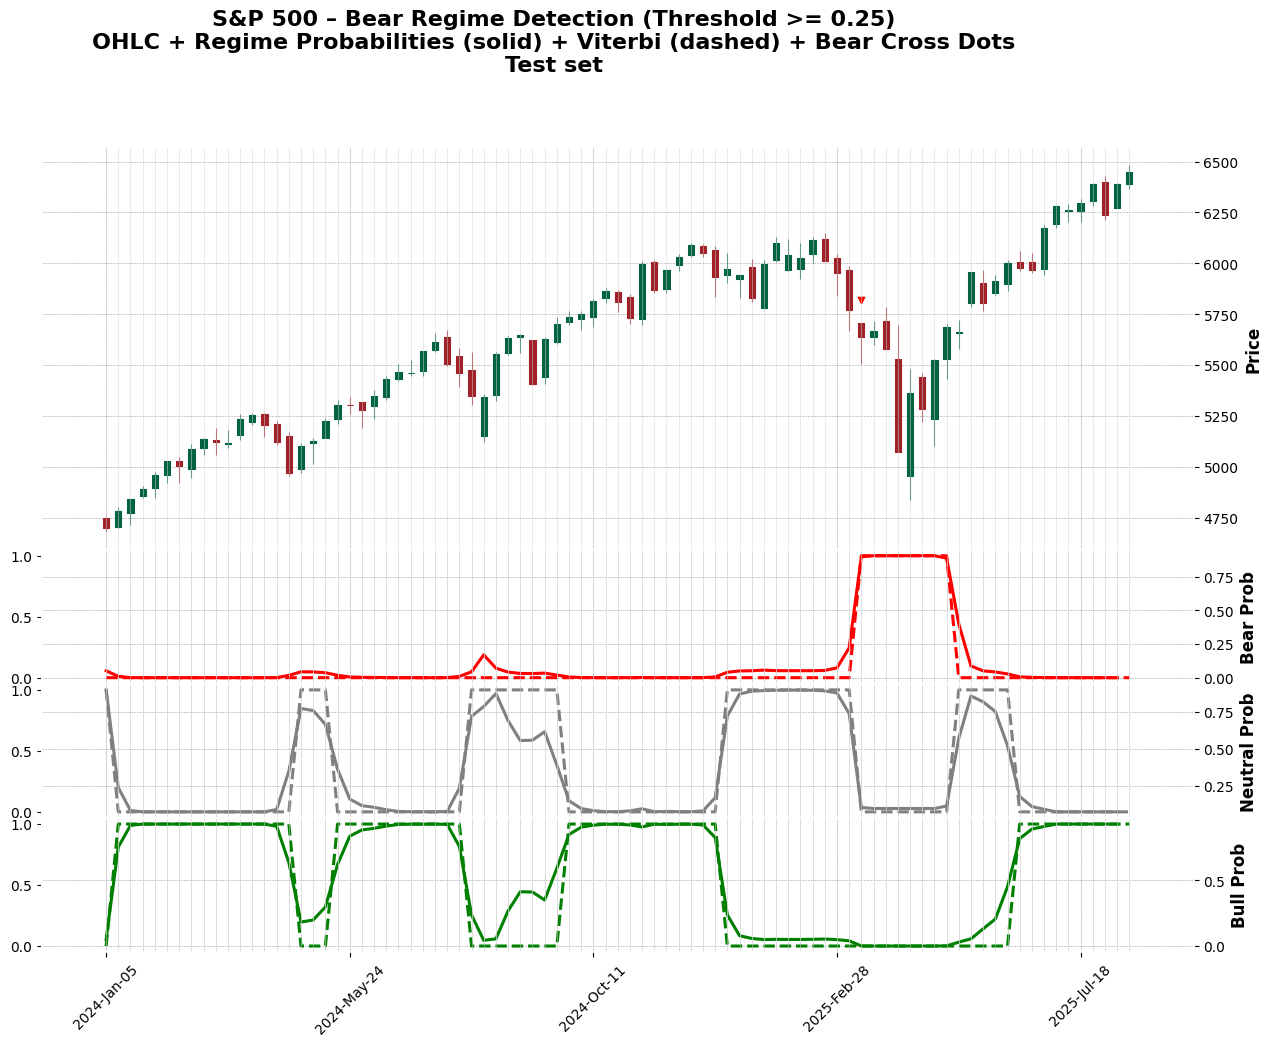

In [9]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import functions  # your custom functions

# --- Ensure datetime index ---
if not isinstance(df_test.index, pd.DatetimeIndex):
    df_test = df_test.set_index(pd.to_datetime(df_test['date']))

# --- Viterbi decoding on test data ---
viterbi_states = model._viterbi(df_test['return'].values)
df_test['Vit_state_0'] = (np.array(viterbi_states) == 0).astype(float)
df_test['Vit_state_1'] = (np.array(viterbi_states) == 1).astype(float)
df_test['Vit_state_2'] = (np.array(viterbi_states) == 2).astype(float)

# --- Forecast next state probabilities ---
probs_states, probs_obs = functions.forecast_all_next_states_and_observations(
    model, df_test['return'].values
)

# --- Assign probabilities (aligned, except last row) ---
df_test.loc[df_test.index[:-1], 'P_next_state_0'] = probs_states[:, 0]
df_test.loc[df_test.index[:-1], 'P_next_state_1'] = probs_states[:, 1]
df_test.loc[df_test.index[:-1], 'P_next_state_2'] = probs_states[:, 2]

# --- Detect Bear Prob cross 0.25 upwards ---
bear_prob = df_test['P_next_state_1']
bear_cross = (bear_prob.shift(1) < 0.25) & (bear_prob >= 0.25)

# --- Place marker slightly above price line ---
marker_positions = np.where(bear_cross, df_test['high'] * 1.02, np.nan)
bear_dot_ap = mpf.make_addplot(marker_positions, type='scatter', markersize=20, marker='v', color='red')

# --- Probability panels with Viterbi overlay ---
apds = [
    mpf.make_addplot(df_test['P_next_state_1'], panel=1, color='red', ylabel='Bear Prob'),
    mpf.make_addplot(df_test['Vit_state_1'], panel=1, color='red', linestyle='--'),

    mpf.make_addplot(df_test['P_next_state_0'], panel=2, color='gray', ylabel='Neutral Prob'),
    mpf.make_addplot(df_test['Vit_state_0'], panel=2, color='gray', linestyle='--'),

    mpf.make_addplot(df_test['P_next_state_2'], panel=3, color='green', ylabel='Bull Prob'),
    mpf.make_addplot(df_test['Vit_state_2'], panel=3, color='green', linestyle='--'),

    bear_dot_ap
]

# --- Plot ---
fig, axes = mpf.plot(
    df_test,
    type='candle',
    style='charles',
    addplot=apds,
    panel_ratios=(3, 1, 1, 1),
    ylabel='Price',
    volume=False,
    figscale=2,
    returnfig=True,
    tight_layout=False
)

# Combine main title + subtitle in one suptitle
fig.suptitle(
    "S&P 500 – Bear Regime Detection (Threshold >= 0.25)\n"
    "OHLC + Regime Probabilities (solid) + Viterbi (dashed) + Bear Cross Dots\n"
    "Test set",
    fontsize=16,
    y=1  # adjust vertical position
)

# --- Draw vertical grid lines on all panels ---
x_locs = range(len(df_test))
for ax in axes:
    for x in x_locs:
        ax.axvline(x=x, color='lightgray', linewidth=0.5, alpha=0.7)

plt.show()

# 📊 Results

In [10]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# --- Threshold for Bear probability cross ---
threshold = 0.25

# --- Compute bear_cross signals ---
bear_prob_train = df_train['P_next_state_1']
bear_cross_train = (bear_prob_train.shift(1) < threshold) & (bear_prob_train >= threshold)

bear_prob_test = df_test['P_next_state_1']
bear_cross_test = (bear_prob_test.shift(1) < threshold) & (bear_prob_test >= threshold)

# --- Generate and display Bear table ---
table_bear = functions.generate_bear_performance_table(df_train, df_test, bear_cross_train, bear_cross_test)

print("Bear Regime Performance Table (Signals = Bear Prob Cross 0.25 Upwards, Next Open to Horizon Close)")
display(HTML(table_bear.to_html(classes='table table-striped table-hover table-condensed')))

Bear Regime Performance Table (Signals = Bear Prob Cross 0.25 Upwards, Next Open to Horizon Close)


,Train Signals,Train Negatives,Train Negative Ratio,Test Signals,Test Negatives,Test Negative Ratio
Horizon,,,,,,
1,29,17,58.62%,1,0,0.00%
4,29,13,44.83%,1,1,100.00%
6,29,11,37.93%,1,1,100.00%
10,29,12,41.38%,1,0,0.00%
